In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_training_sin_proc_v2.csv')
df_test = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_testing_sin_proc_v2.csv')

In [2]:
### Remplazar los truthful con 0 y deceptive con 1 en la columna deceptive
df_train = df_train.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})
df_test = df_test.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})

In [3]:
train_dec_a = df_train.iloc[:, 0]
#validation_dec_a = validation_set.iloc[:, 0]
test_dec_a = df_test.iloc[:, 0]

train_dec_a.columns = ['train_dec_a']
#validation_dec_a.columns = ['validation_dec_a']
test_dec_a.columns = ['test_dec_a']

In [4]:
print(df_train)

     deceptive                                               text
0            0  -0.17674068 0.43587244 -0.6416608 -0.12459087 ...
1            0  -0.1654682 0.4410854 -0.012634787 -0.012707673...
2            0  -0.32845125 -0.19465207 -0.13909712 0.13290861...
3            0  -0.37741926 0.16427028 -0.27997202 -0.28371224...
4            0  0.12777051 0.11490288 -0.36055514 0.27289224 0...
..         ...                                                ...
592          0  0.31424373 0.15137303 -0.22515695 0.36719048 -...
593          0  0.47048765 0.47295353 -0.0045212787 0.07379096...
594          0  0.815912 0.26509556 0.029857883 -0.21518761 -0...
595          0  0.48300835 0.6162463 0.06847672 0.2588637 -0.3...
596          0  -0.25403798 0.11573458 -0.16301572 0.062248822...

[597 rows x 2 columns]


In [5]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [6]:
import numpy
arrays = {}
## Train dataset
for i in range(0, len(x_train[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_train])

train_ext = pd.DataFrame(y_train, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    train_ext = train_ext.join(dataframe, how="inner")
    
train_ext = train_ext.drop(['deceptive'],axis=1)
## Test dataset

for i in range(0, len(x_test[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_test])

test_ext = pd.DataFrame(y_test, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    test_ext = test_ext.join(dataframe, how="inner")
    
test_ext = test_ext.drop(['deceptive'],axis=1)


In [7]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
#x_validation, y_validation = np.asarray(x_validation), np.asarray(y_validation)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
#x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

In [8]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
#x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1]) # X_train 
#print("Validation data shape:", x_validation.shape)
X_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (597, 300)
Test data shape: (198, 300)


In [9]:
print(X_train)

[[[-0.17674068  0.43587244 -0.6416608  ... -0.71878403  2.1983664
   -0.27194586]]

 [[-0.1654682   0.4410854  -0.01263479 ... -0.6191385   1.4874983
   -0.32602754]]

 [[-0.32845125 -0.19465207 -0.13909712 ... -1.5118456   1.3487415
   -0.38114238]]

 ...

 [[ 0.815912    0.26509556  0.02985788 ... -1.2424698   2.470738
   -0.7296655 ]]

 [[ 0.48300835  0.6162463   0.06847672 ... -1.202118    1.5697993
   -0.7954692 ]]

 [[-0.25403798  0.11573458 -0.16301572 ... -1.1126655   1.6860282
   -0.48406893]]]


## Primer MODELO -- mediante LSTM

In [10]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(128, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.01))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(32, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(128, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model


In [11]:
# create the autoencoder model
model = autoencoder_model(X_train)
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 300)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 592       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 32)            

In [12]:
import time
from keras.callbacks import TensorBoard

# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data

for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 300 
    batch_size = 64
    
    tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, shuffle=True, verbose=0, callbacks=[tb]).history 
    end = time.time()
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)
    

Fit model on training data...
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Time to training model: 53.16401386260986


In [13]:
X_train.shape

(597, 1, 300)

                0
count  300.000000
mean     0.273643
std      0.332432
min      0.213843
25%      0.214561
50%      0.215279
75%      0.216314
max      3.882713


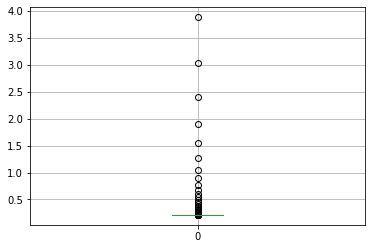

In [14]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [15]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 0.4930036962032318


In [16]:
print("Best MSE on Validation Set =", max(history['val_mse']))

Best MSE on Validation Set = 0.37094423174858093


In [17]:
loss = model.evaluate(X_train, X_train, verbose=0)
print(loss)

[0.214518204331398, 0.21415437757968903, 0.07596001029014587, 289.6494445800781, 0.016859086230397224, 0.8976175785064697]


In [18]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.214518204331398
mae 0.21415437757968903
mse 0.07596001029014587
mape 289.6494445800781
msle 0.016859086230397224
cosine_proximity 0.8976175785064697


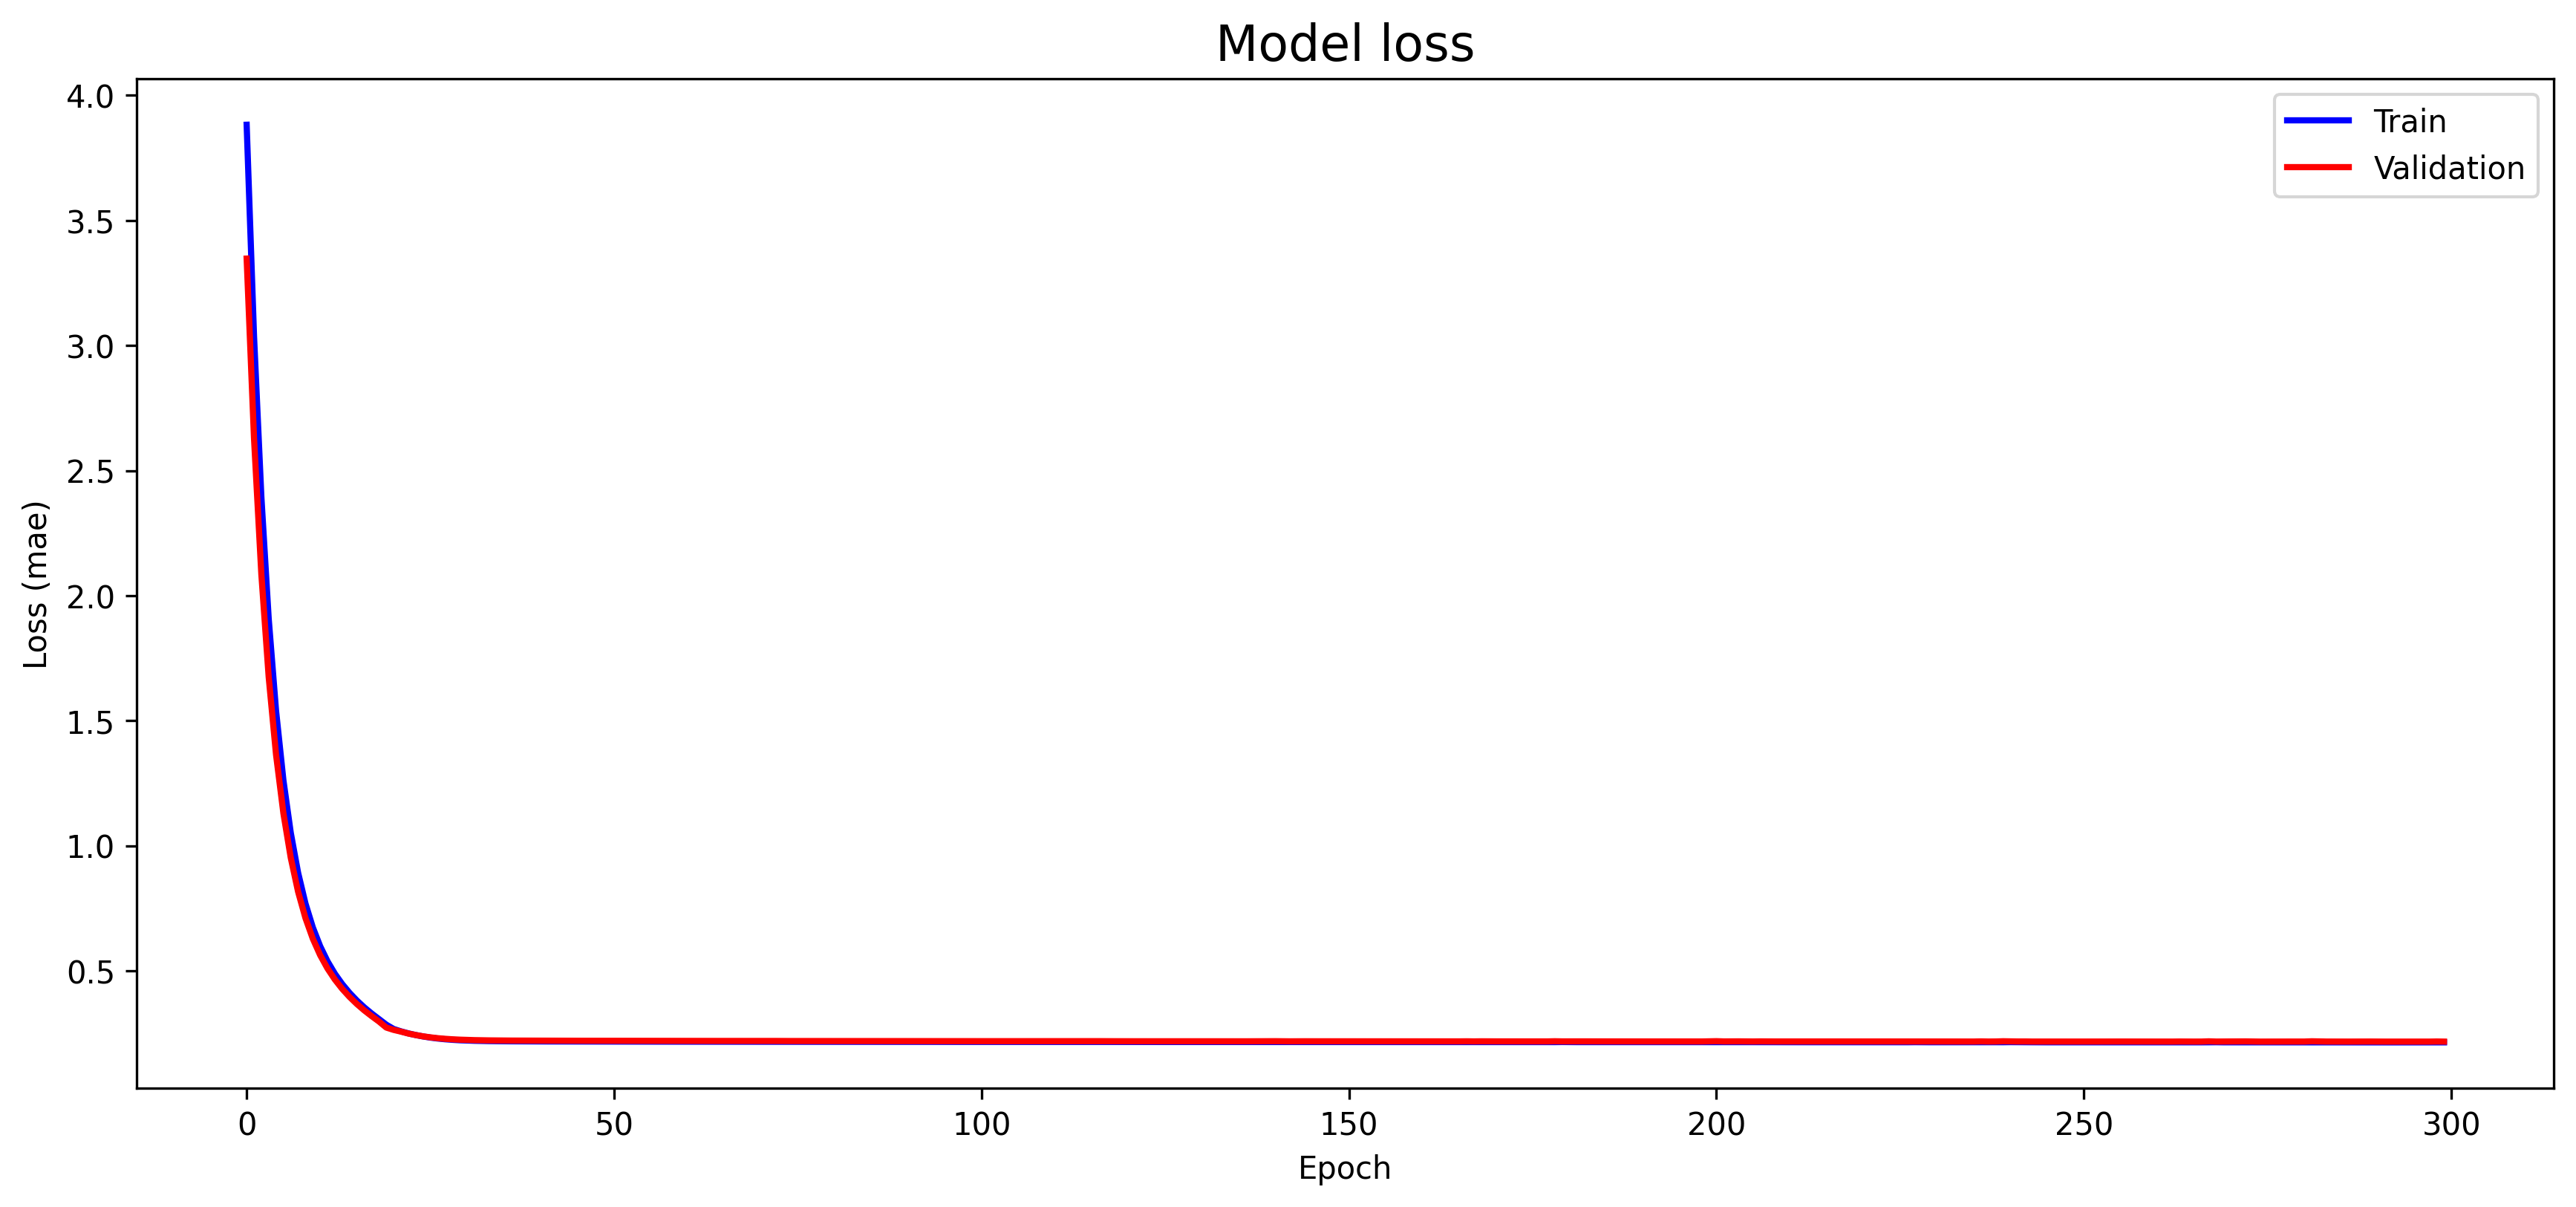

In [19]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



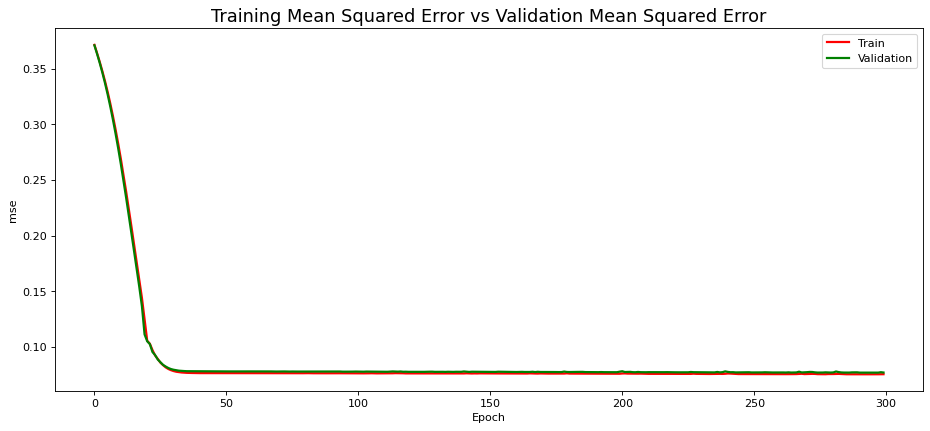

In [20]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

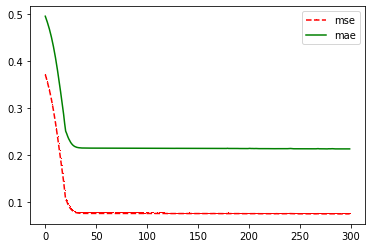

In [21]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

## Distributon of Loss Function

/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

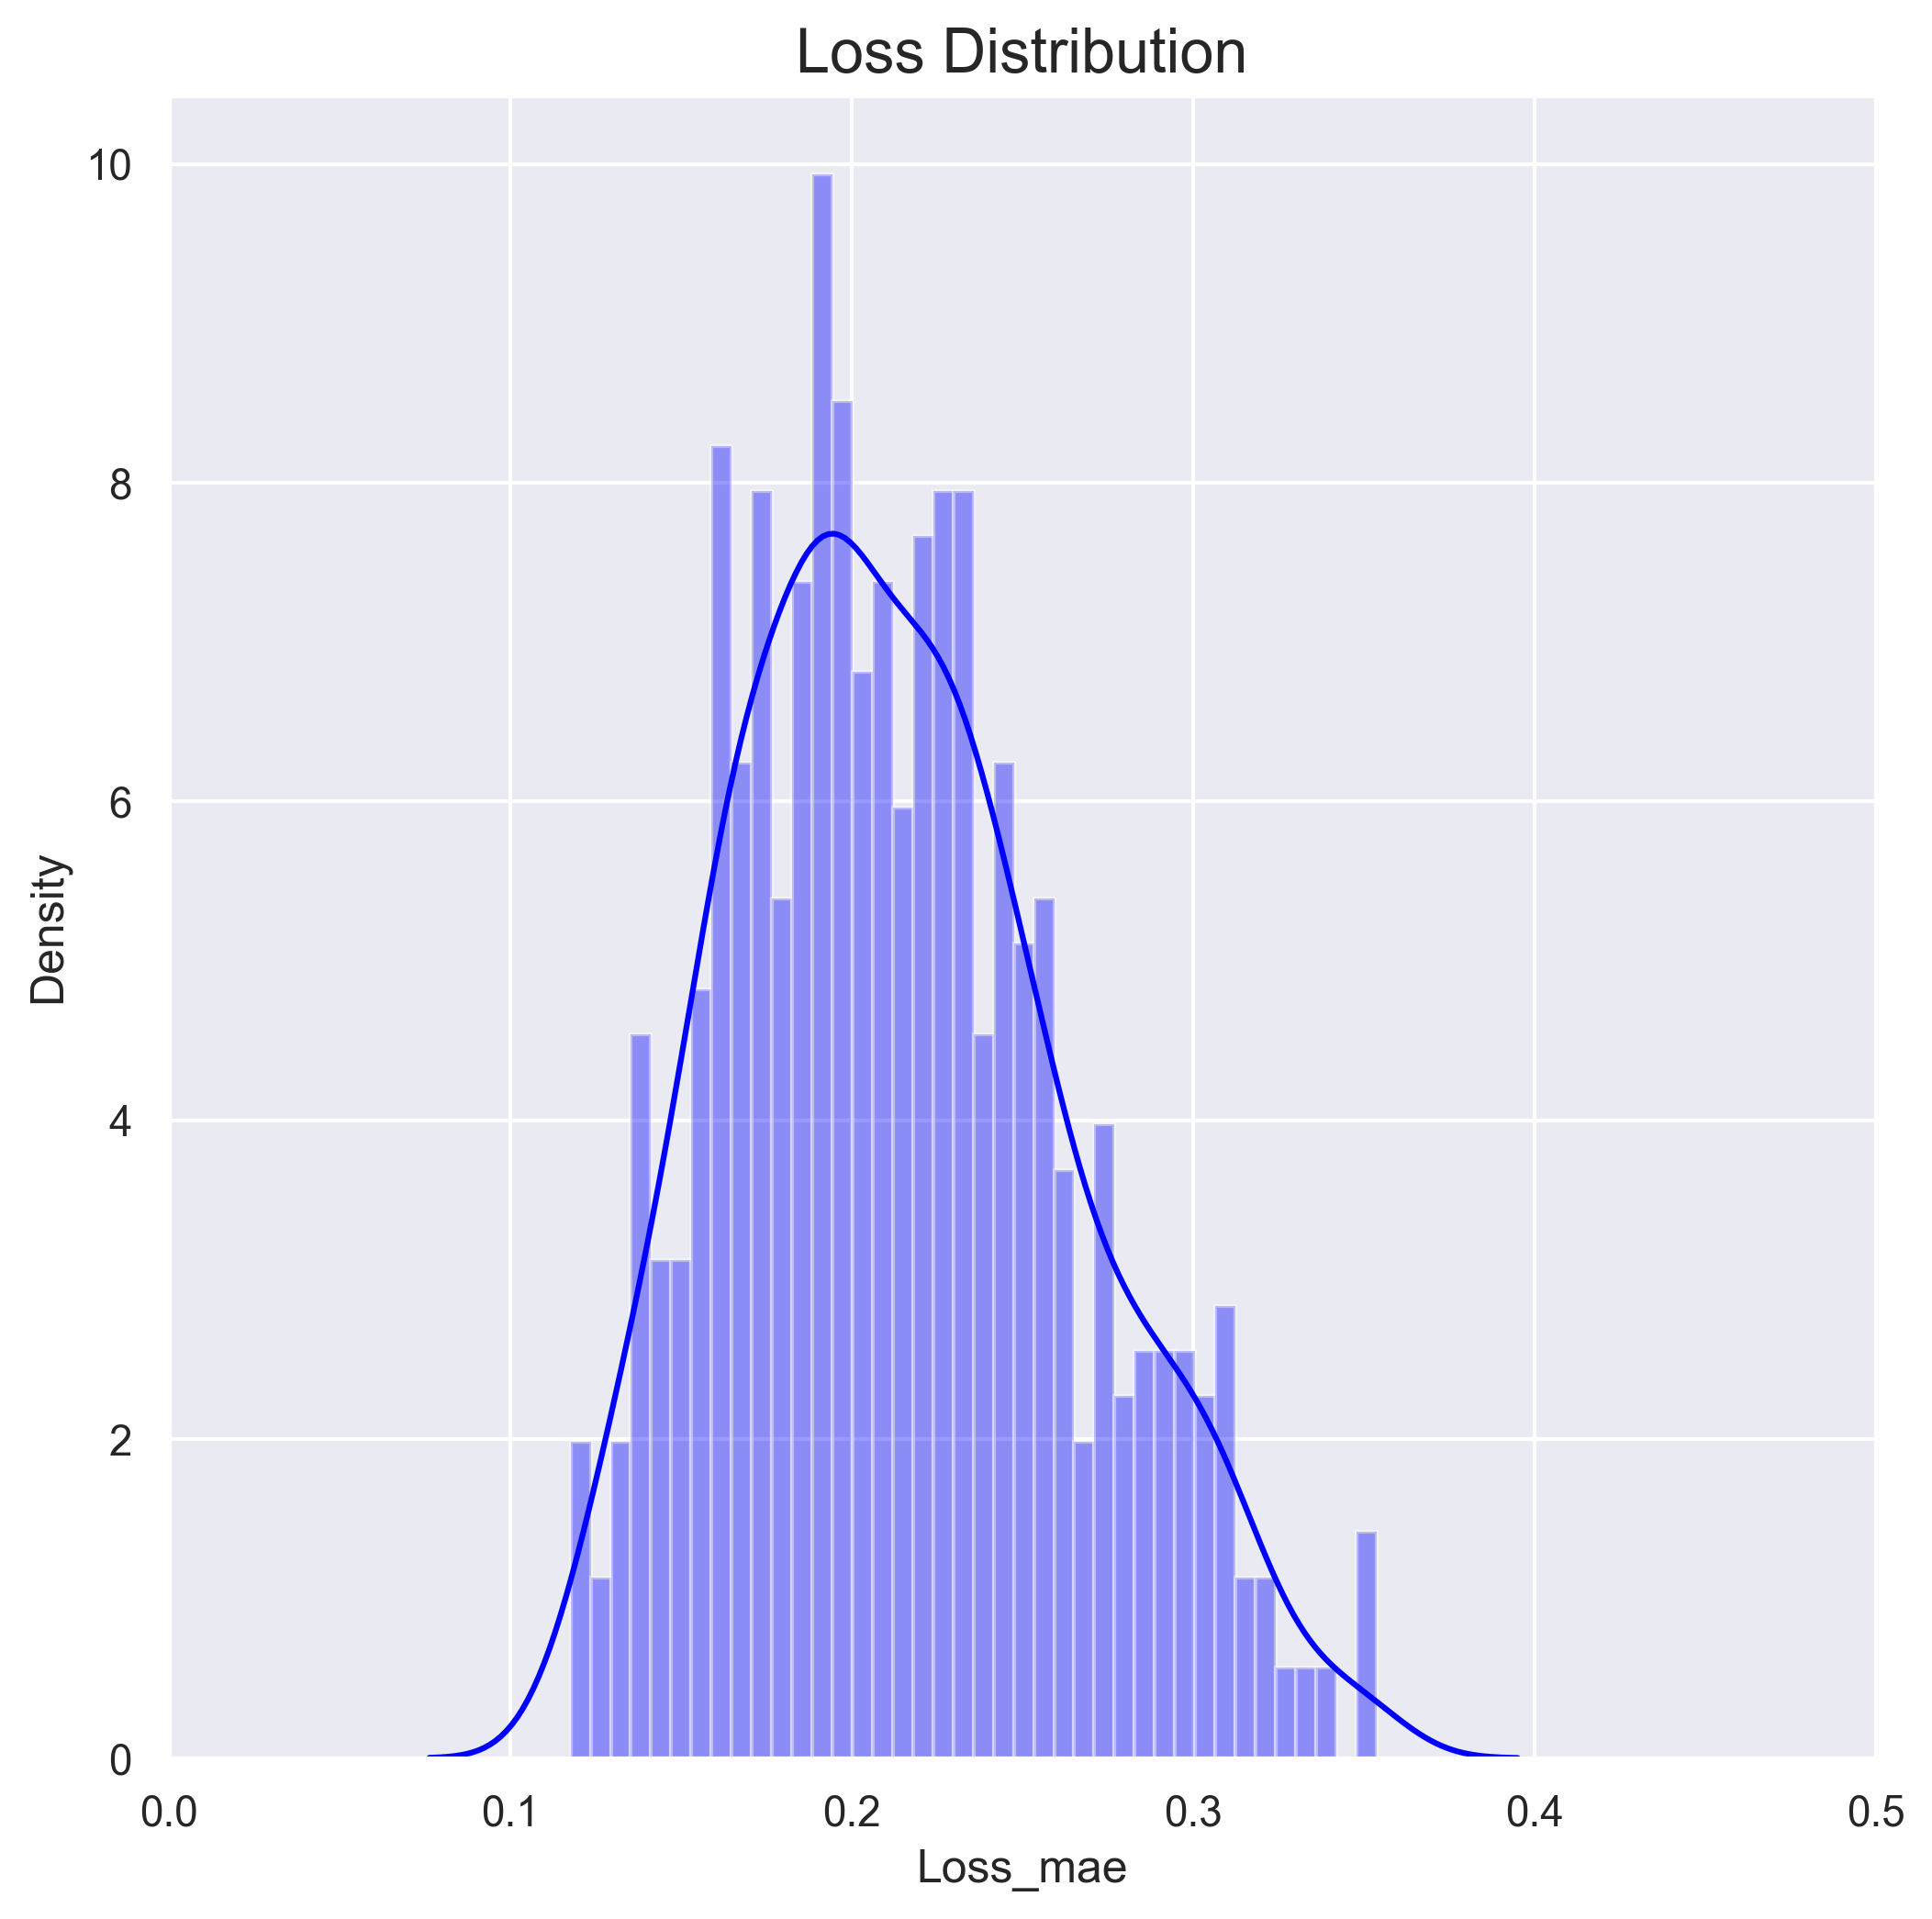

In [22]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_ext.columns)
X_pred.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,0.5])


/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Loss_mae,Threshold,Anomaly
0,0.669111,0.9,False
1,0.733586,0.9,False
2,0.603545,0.9,False
3,0.748048,0.9,False
4,0.667966,0.9,False


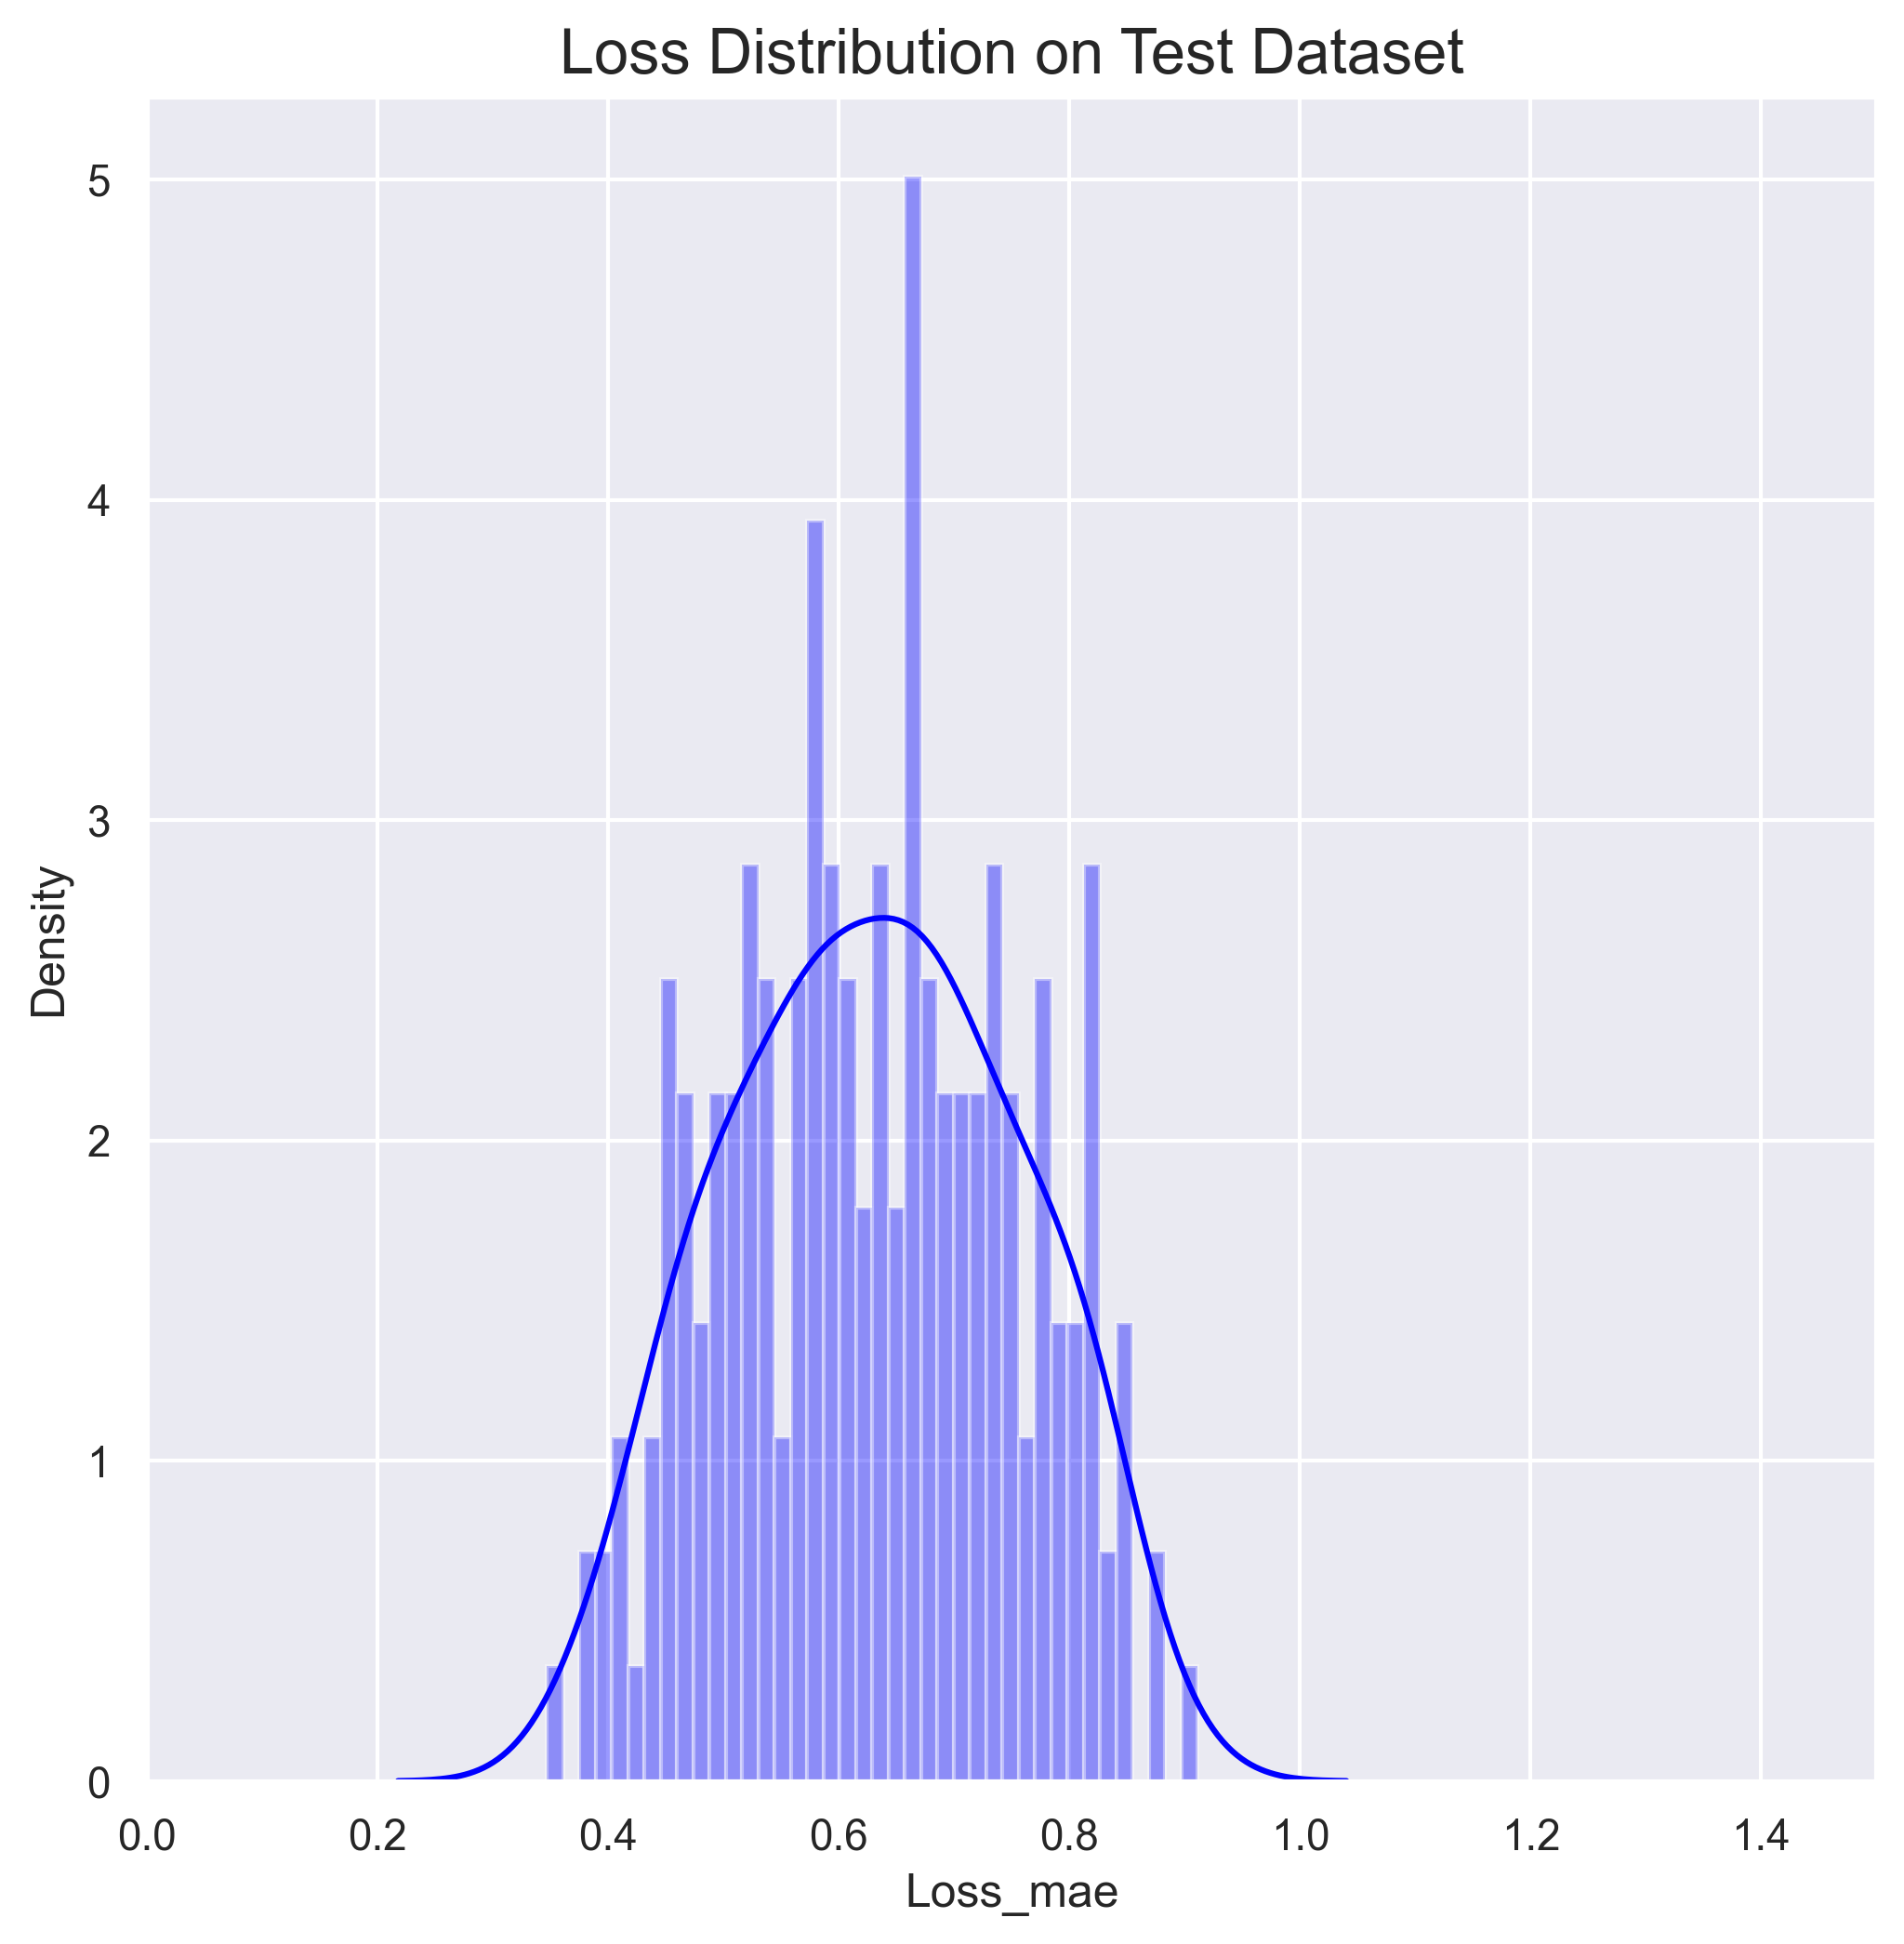

In [23]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


scored = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution on Test Dataset', fontsize=16)
sns.distplot(scored['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,1.5])
scored['Threshold'] = 0.9
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [24]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   198 non-null    float32
 1   Threshold  198 non-null    float64
 2   Anomaly    198 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.6 KB


In [25]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
50,0.911155,0.9,True


In [26]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_ext.columns)
X_pred_train.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.9
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

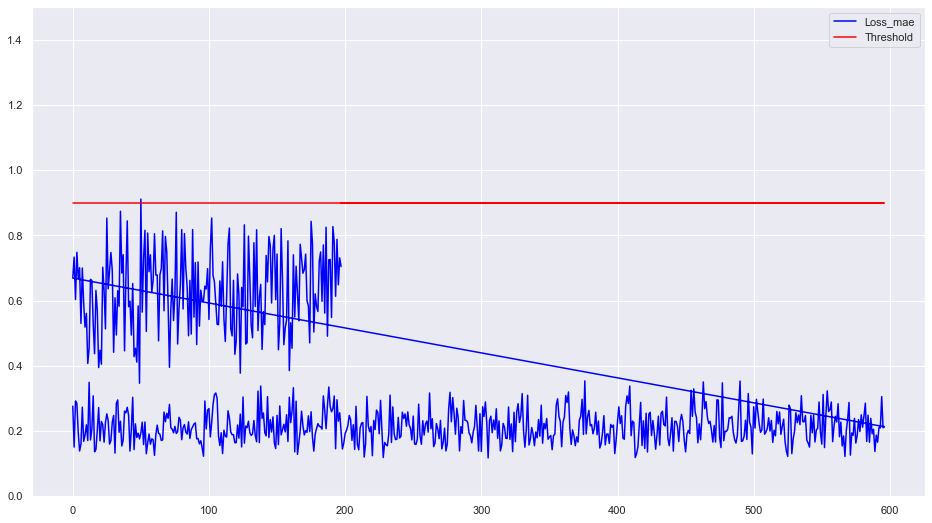

In [27]:
scored.plot(figsize=(16,9), ylim=[0,1.5], color=['blue','red'])

## Determinación de threshold con (max)

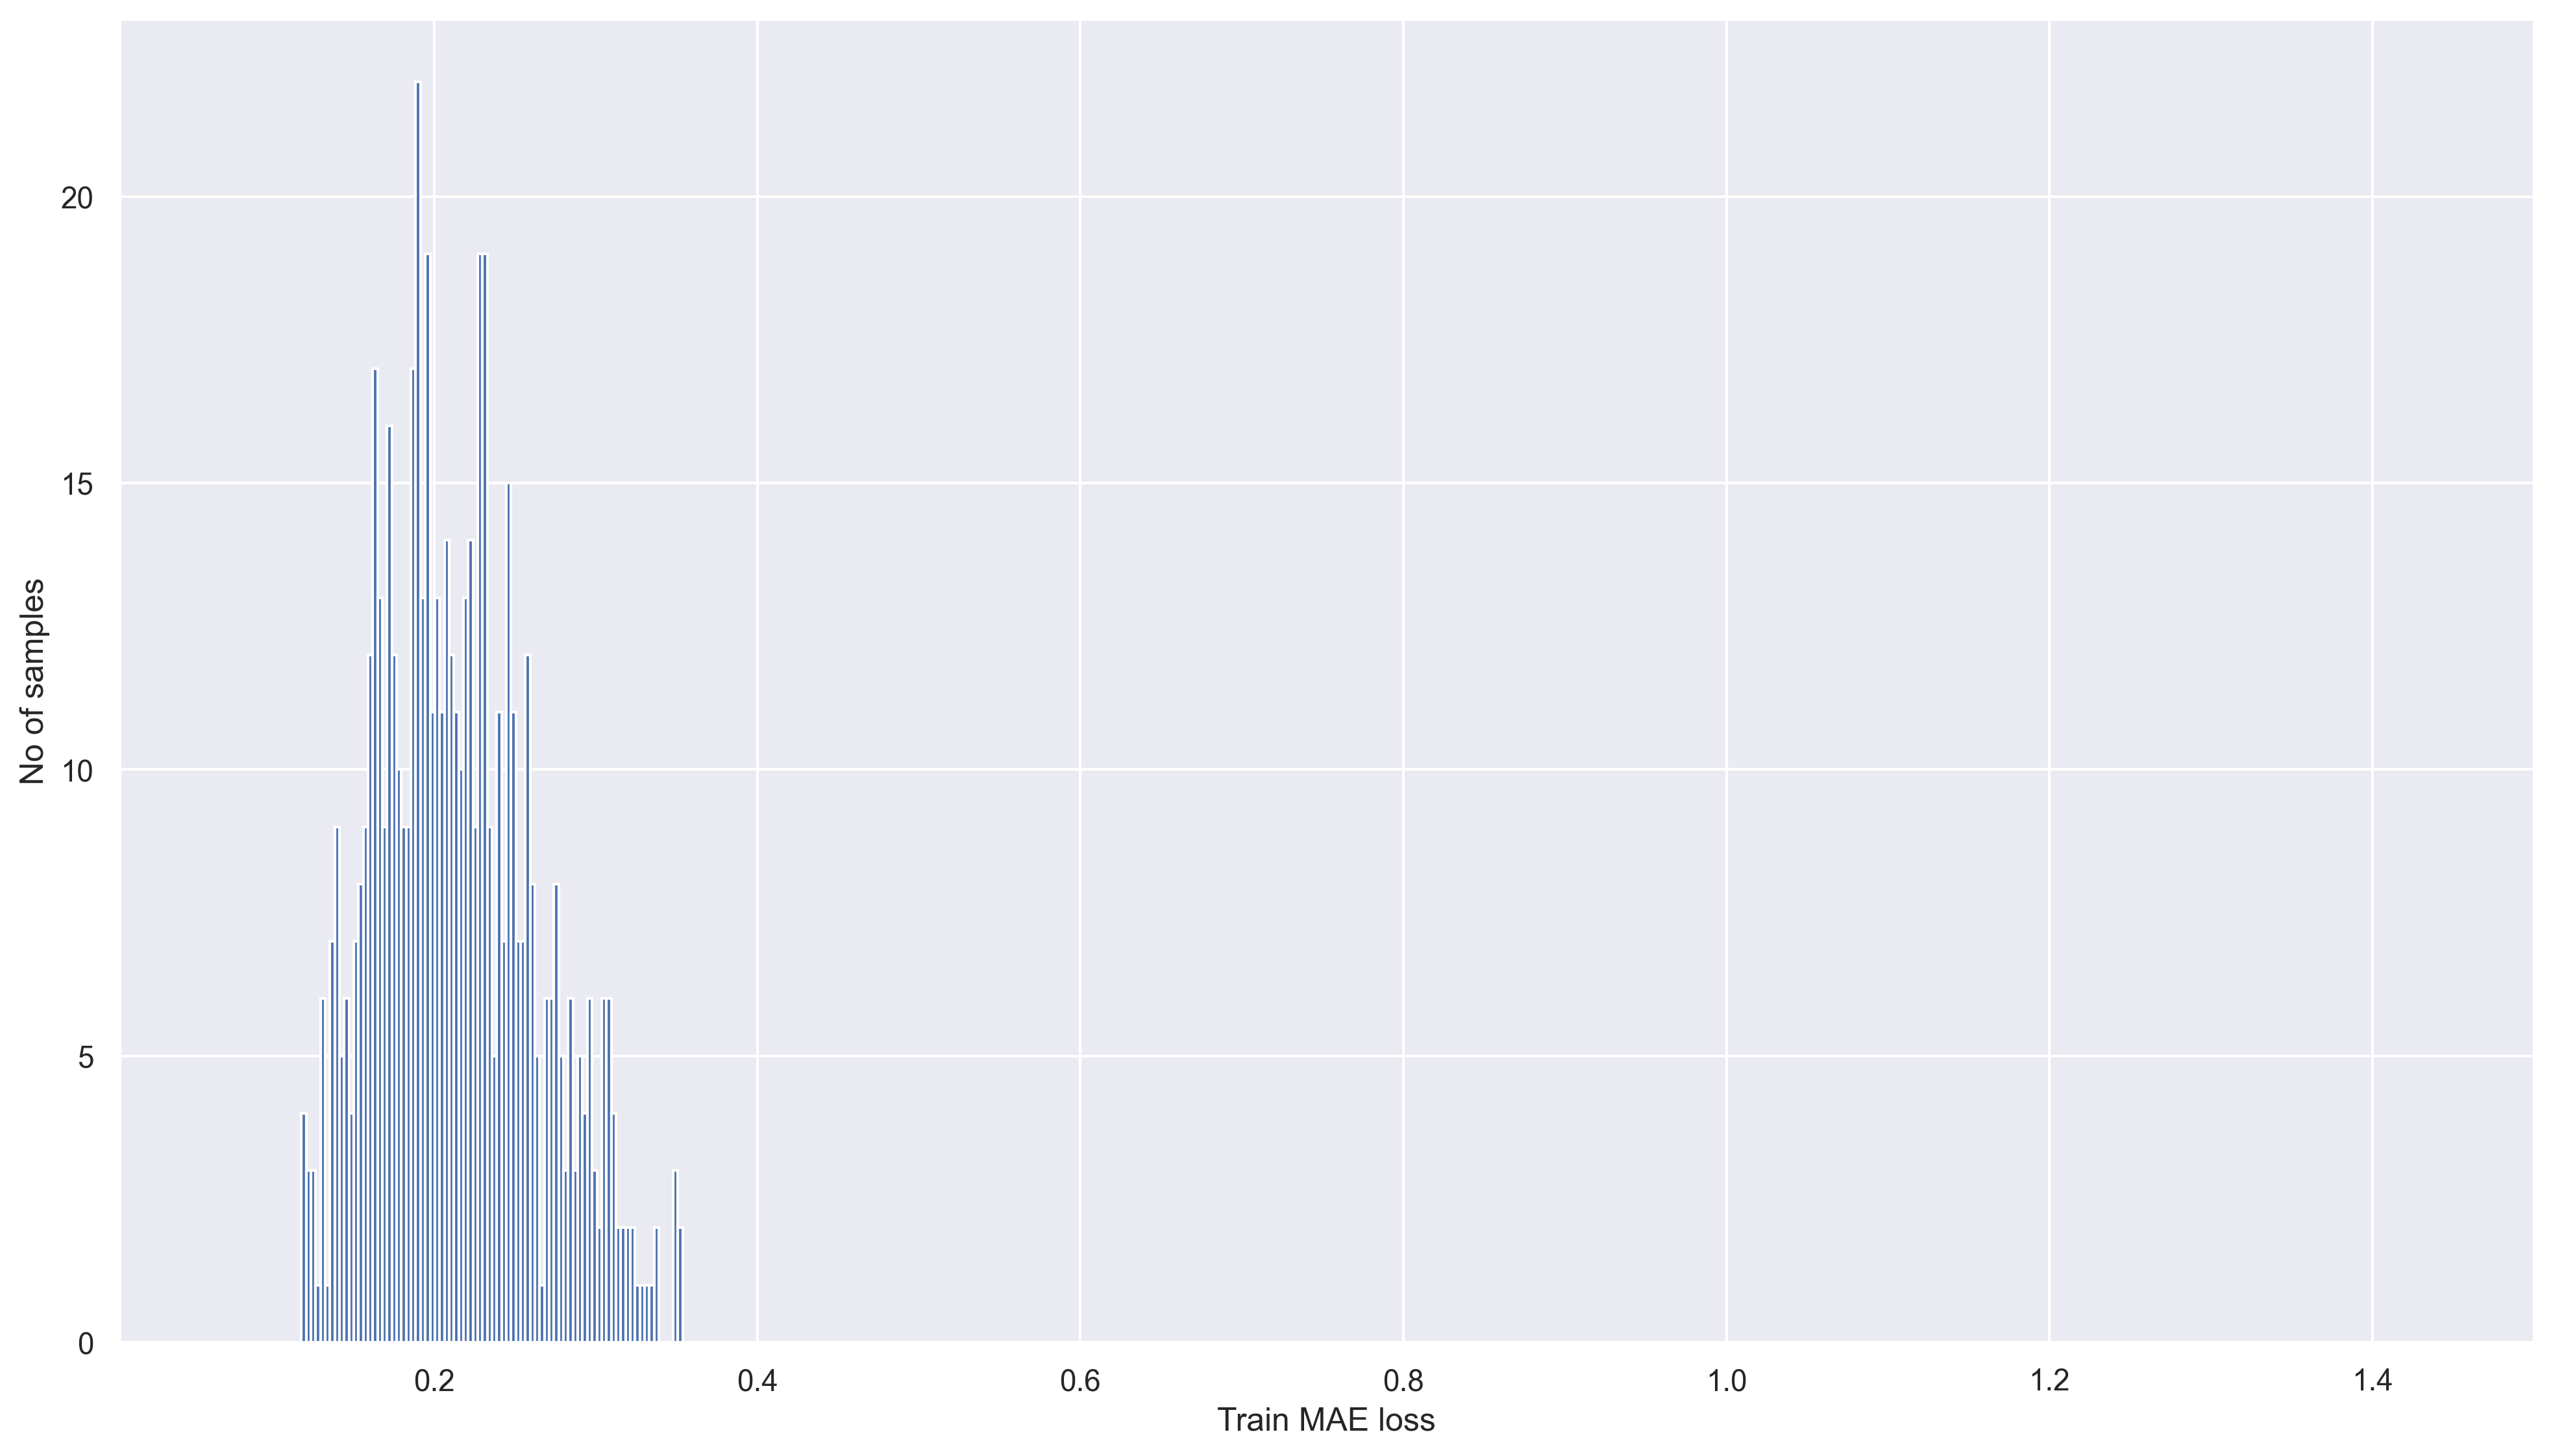

Reconstruction error threshold:  0.353802


In [28]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)
x_train_pred = x_train_pred.reshape(x_train_pred.shape[0], x_train_pred.shape[2])
x_train_pred = pd.DataFrame(x_train_pred, columns=train_ext.columns)
x_train_pred.index = train_ext.index

score = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
score['train_mae_loss'] = np.mean(np.abs(x_train_pred - Xtrain), axis=1)

plt.figure(figsize=(16,9), dpi= 300)
plt.hist(score['train_mae_loss'], bins= 80)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.005,1.5])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(score['train_mae_loss'])
print("Reconstruction error threshold: ", threshold)


## Determinación de threshold con (mean + std)

In [29]:
reconstructions = model.predict(X_train)
train_loss = np.mean(np.abs(reconstructions - X_train), axis=1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.38764188


## Determinación de Clasificación. (dataset de train)

In [253]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
# calculate the loss on the train dataset
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_ext.columns)
X_pred.index = train_ext.index


In [254]:
error_df = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
error_df['Reconstruction_error'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
error_df['True_class'] = train_dec_a
error_df.head()

,Reconstruction_error,True_class
0,0.214441,0
1,0.228142,0
2,0.181000,0
3,0.167877,0
4,0.257940,0


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


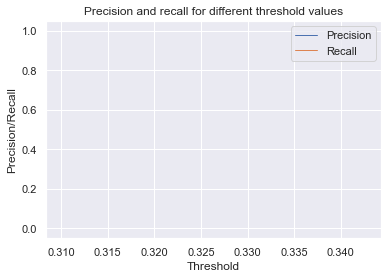

In [255]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


Text(0.5, 0, 'False Positive Rate')

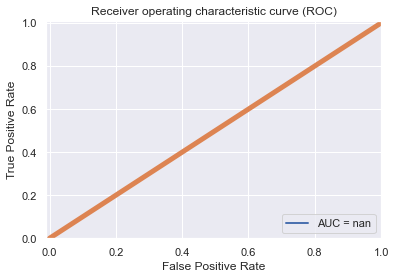

In [256]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


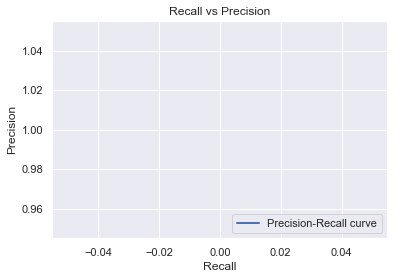

In [257]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.legend(loc='lower right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

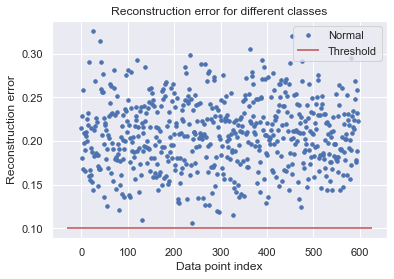

In [258]:
threshold_fixed = 0.1
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix


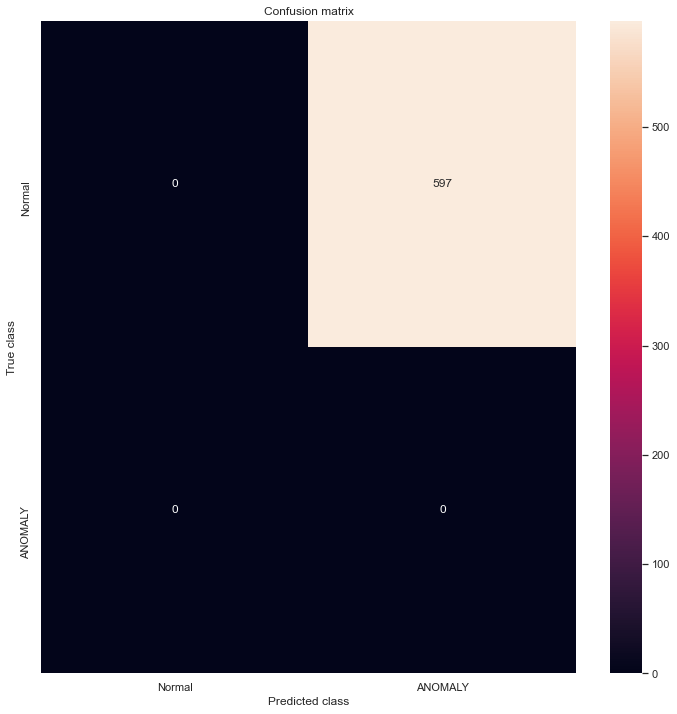

In [259]:
LABELS = ["Normal","ANOMALY"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Reconstruction error - Test set

Text(0.5, 1.0, 'Reconstruction error - Train set')

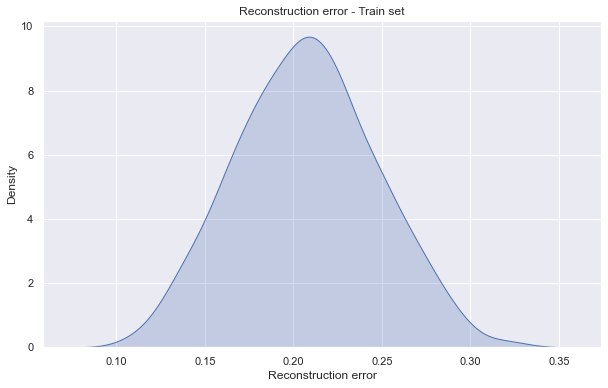

In [260]:
plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='ANOMALY', shade=True, clip=(0,10))
plt.xlabel('Reconstruction error')
plt.title('Reconstruction error - Train set')


## Determinación de Clasificación. Test

In [36]:
# calculate the loss on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


In [37]:
error_df = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
error_df['True_class'] = test_dec_a
error_df.head()

## Otra variante
"""
mse = np.mean(np.power(Xtest - X_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()
"""

"\nmse = np.mean(np.power(Xtest - X_pred, 2), axis=1)\nerror_df = pd.DataFrame({'Reconstruction_error': mse,\n                        'True_class': test_y})\nerror_df.describe()\n"

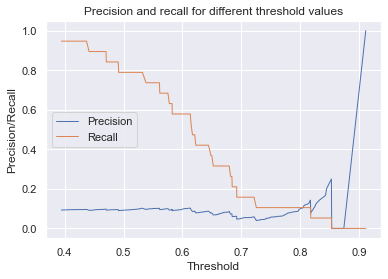

In [38]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [39]:
print(threshold_rt)

[0.39462852 0.395445   0.40495142 0.40712723 0.41139    0.42822123
 0.43537253 0.4372547  0.44153732 0.44596335 0.44785005 0.44920298
 0.45020863 0.45296347 0.45380983 0.4538207  0.46487713 0.46523917
 0.46684438 0.46691954 0.47036058 0.47079268 0.47468194 0.47577402
 0.4765565  0.48604783 0.49094278 0.49182683 0.4922225  0.49446422
 0.49454764 0.49750942 0.50362384 0.5054671  0.50790316 0.5132961
 0.51464695 0.51589066 0.51864463 0.5218198  0.52335286 0.52623576
 0.52635103 0.5272774  0.5285984  0.5299556  0.5301087  0.53202367
 0.53817046 0.5388743  0.5404119  0.5422205  0.54275656 0.5481556
 0.5493573  0.55001384 0.560959   0.5615747  0.56469434 0.5663408
 0.56657356 0.56869465 0.5699195  0.5742817  0.5753872  0.57773644
 0.58067584 0.58132374 0.5819405  0.58235353 0.5824785  0.58264077
 0.58364475 0.5841406  0.587791   0.5917093  0.592601   0.5931018
 0.59773993 0.59838015 0.5994205  0.59990805 0.60069185 0.6028066
 0.6035453  0.6086886  0.6101939  0.61332834 0.6146766  0.6170276
 

## ROC CURVE CHECK

Text(0.5, 0, 'False Positive Rate')

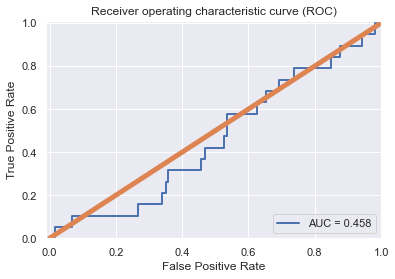

In [40]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


## RECALL VS PRECISION THRESHOLDING

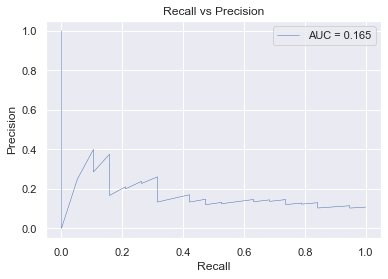

In [324]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
pr_auc = auc(recall_rt, precision_rt,)

plt.plot(recall_rt, precision_rt, linewidth=0.5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


## Reconstruction Error vs Threshold Check

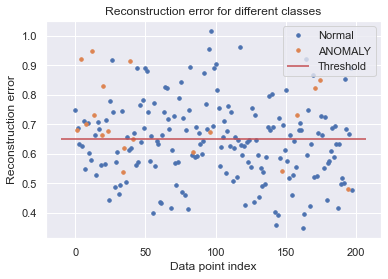

In [326]:
threshold_fixed = 0.65
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()



## Confusion Matrix

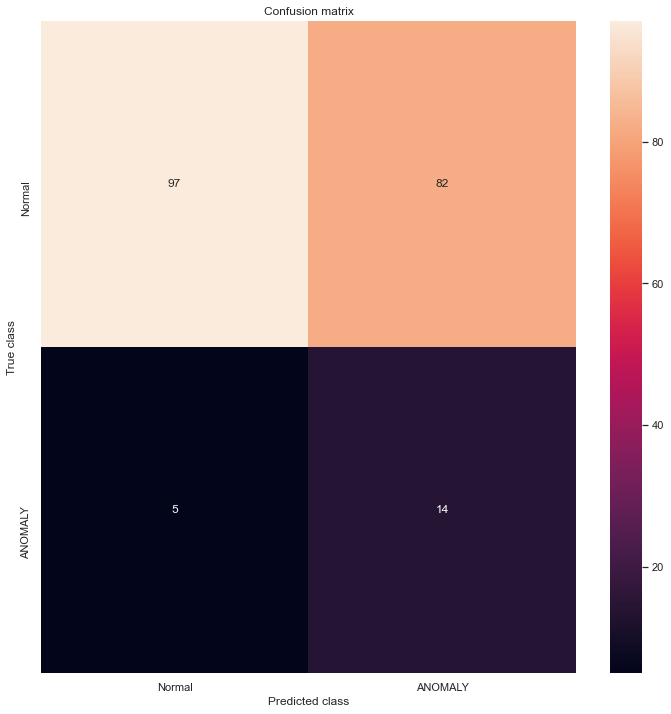

In [327]:
LABELS = ["Normal","ANOMALY"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



## MODEL STATS

In [ ]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [ ]:
print_stats(error_df.True_class, pred_y)

In [ ]:
p = precision_score(error_df.True_class, pred_y,average='weighted')
r = recall_score(error_df.True_class, pred_y,average='weighted')
f = fbeta_score(error_df.True_class, pred_y, beta= 0.5,average='weighted')
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

In [ ]:
## Modified Classification report -- Vanilla
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y,average='weighted')
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5, average='weighted')
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

In [ ]:
## RandomSearch/Bayasian/ RS-iterations optimization Keras Tuner
for threshold_fixed in [0.1, 0.15, 0.2, 0.3]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y)
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print_stats(error_df.True_class, pred_y)

In [ ]:
## Modified LSTM first version
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

In [ ]:
#### Extended LSTM
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.025, 0.045, 0.07, 0.075, 0.08, 0.11]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y)
    f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

## Results 
1. Original LSTM:
    78 - 12
    90 - 11
    102 - 10
    138 - 9
    148 - 8
    151 - 7

2. Extended LSTM:
    65 - 12
    90 - 11
    115 - 10
    146 - 9
    147 - 8
    147 - 7

3. Extended LSTM con mas regularizers y dropout:
    87 - 13
    88 - 12
    89 - 11
    96 - 10
    109 - 9
    110 - 8
    112 - 7
    124 - 6
    

3. Vanilla Model:
    88 - 12
    88 - 11
    99 - 10
    99 - 9
    104 - 8
    105 - 7